[Start here on Ally Invest](https://www.ally.com/api/invest/documentation/getting-started/ "Link to Ally API documentation")

We are going to use a real Ally Invest investment account (my own) to make trades. One advantage of not being rich is not having much to lose. :)

Why Ally? Because RobinHood, which has free trades, does not have one as of this writing. Also, I've found RobinHood, which is an otherwise great service, to choose a clean user interface over granular trade data and options.

Log in (or create an account) on [Ally Invest](https://www.ally.com/invest/ "Ally Invest Create an Account Link"). This is a large online brokerage, part of Ally Bank. It used to be TradeKing and before that Zecco. Brokerages are traded by corporations like baseball cards, but it works much the same as ever. The functionality of Ally Invest's API is probably as good as there is (leave a comment below if you know of better options).

When your account is approved, log in to your dashboard. Navigate on the toolbar Tools > Ally Invest API > Manage Applications. This will take you [here](https://investor.tradeking.com/Modules/Dashboard/dashboard.php):

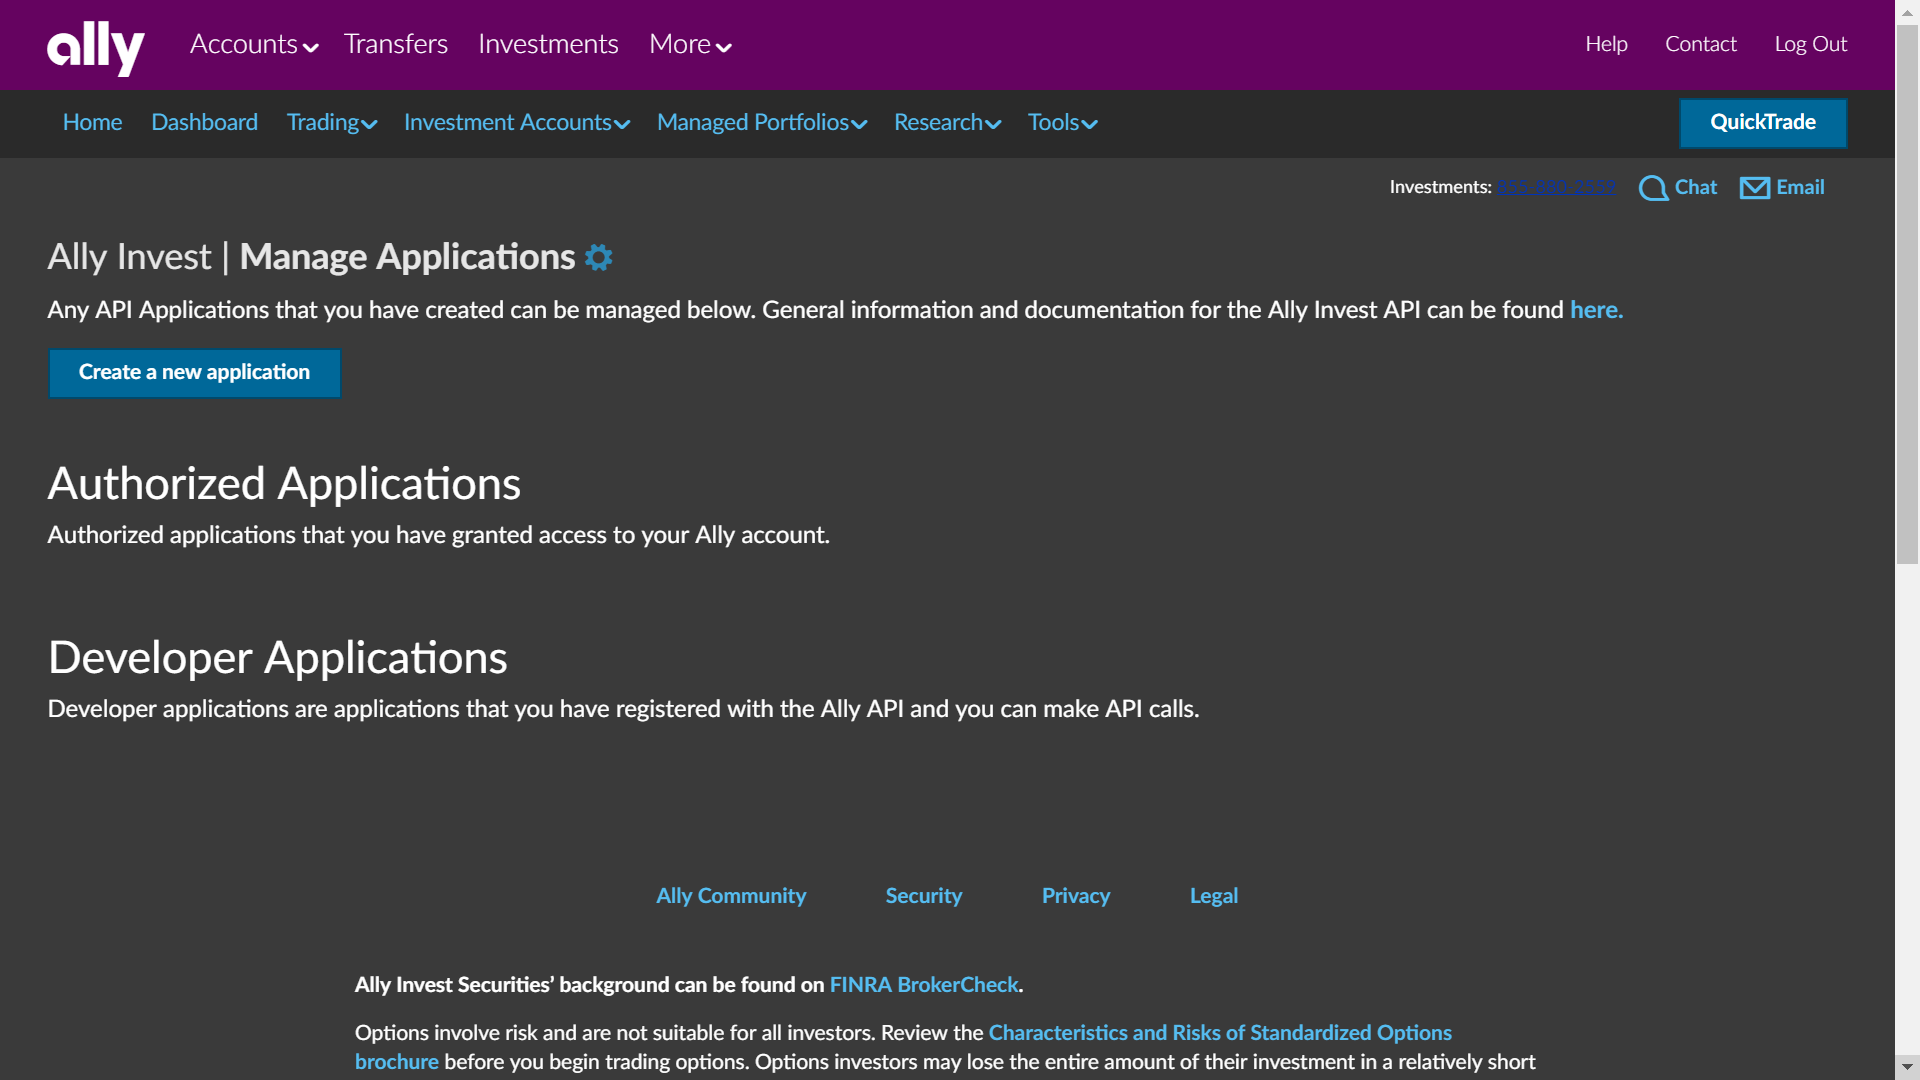

Now create an app for individual use.

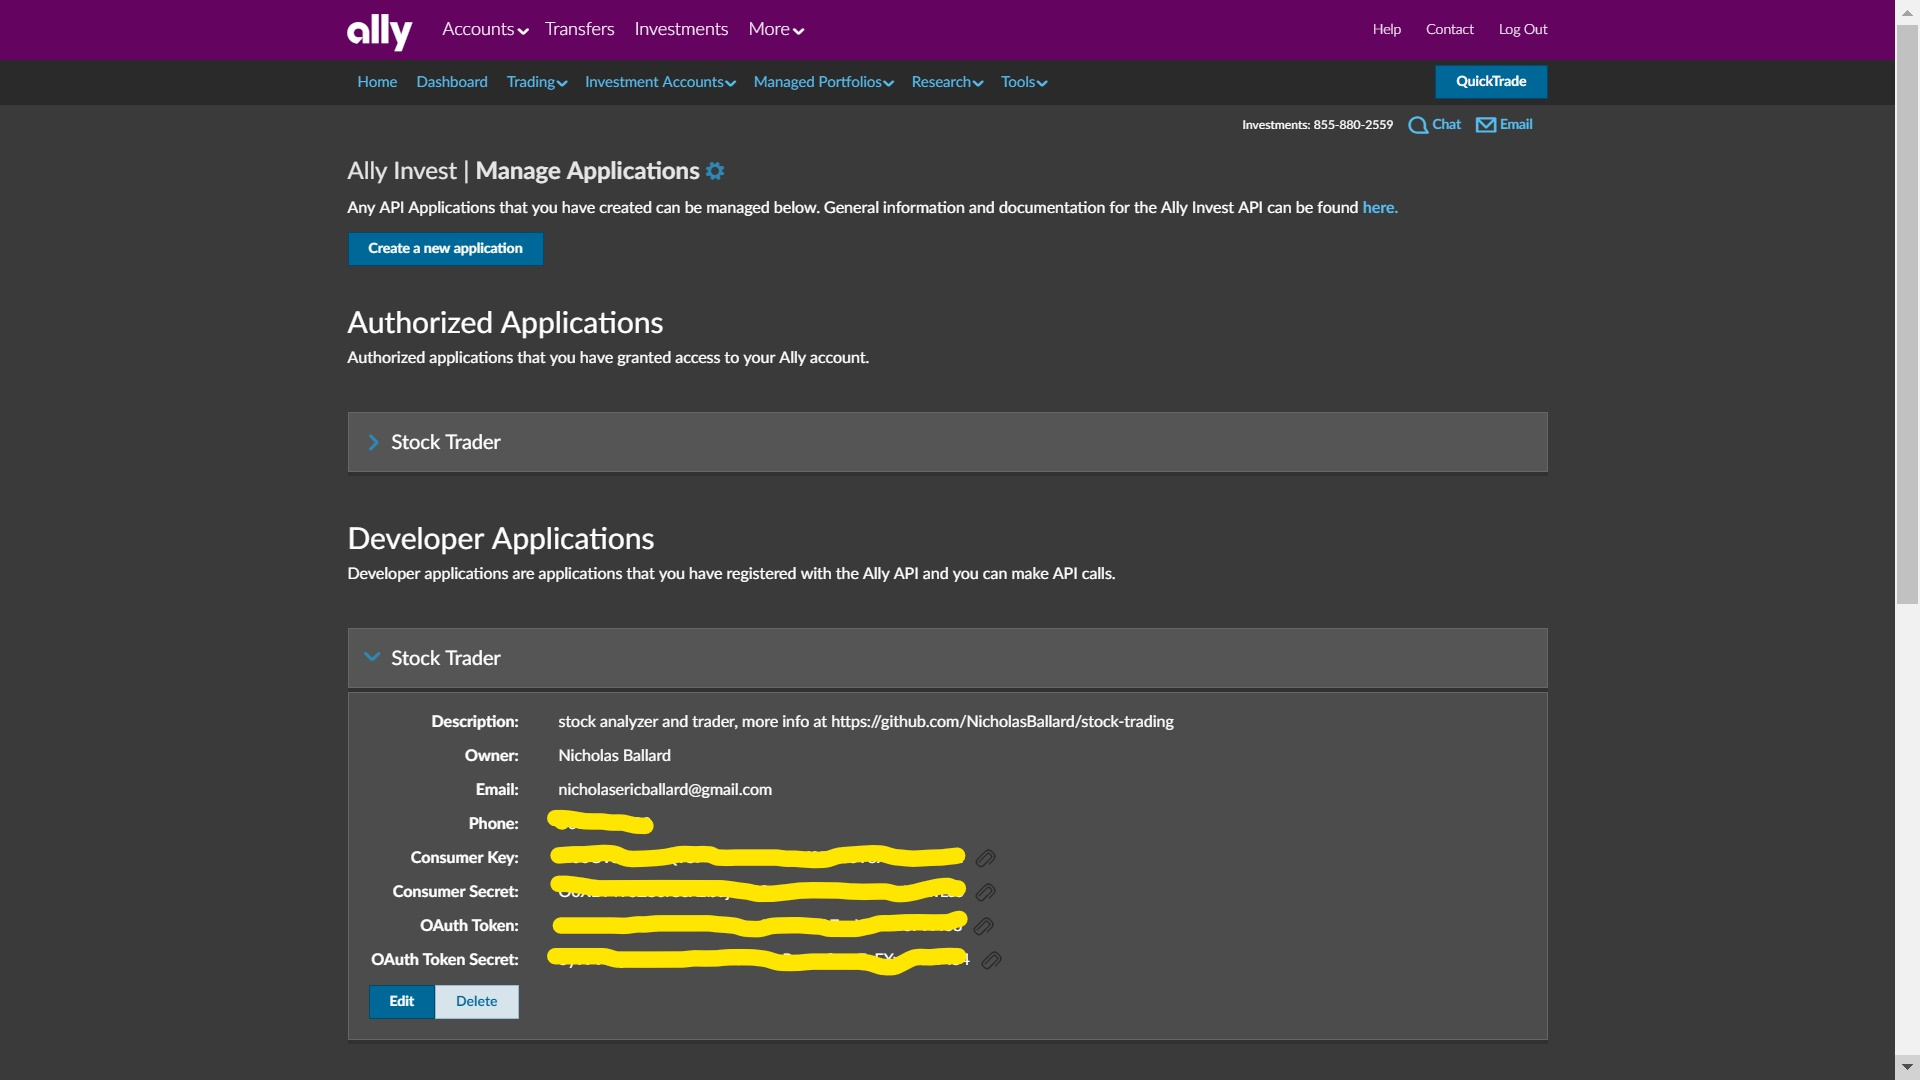

Save these four keys in a safe spot.

>### Limits
>These are the current limits in place:  
>
>-20 requests per minute for trade submission calls (ex: POST /v1/account/12345678/orders.xml)  
>-60 requests per minute for market/quotes calls  
>-180 requests per minute for all other authenticated calls (balances, summary, etc) 

These are all the calls we will need. We are not doing high-frequency microtrading here. We are going for the consistent-and-faster-than-humans type of trade.

Now for making our stock trading app. We will be referring to the [Ally Invest API documentation](https://www.ally.com/api/invest/documentation/getting-started/ "Ally Invest API Documentation") quite a bit.




## Making Our First Call to the Ally Invest API

Danger Will Robinson! We now have the power to buy and sell securities on our account with real money using Python! While that is super-cool, it means we need to test, test, and test again before running something that costs us money. Let's start by sending GET requests for market data.

We are going to use the requests_oauthlib module. This module makes the excellent `oauthlib` library work with the `python-requests` module (known simply as `requests`). Import it from the command line with `pip install requests_oauthlib`. Documentation and source code for this module is here on [GitHub](https://github.com/requests/requests-oauthlib "requests_oauthlib").

If you want to follow along using Node.js, you will find the language well-equipped for work as an OAuth1 client. Install it on your command line with `npm install oauth` and in your app start your file with `var oauth = require('oauth');`. This tutorial will be pure Python 3, but let me know in the comments below if you want to see this implemented in Node or R.



### Signing the Request

Ally requires we sign our request using the [HMAC-SHA1 method](https://en.wikipedia.org/wiki/Hash-based_message_authentication_code "encryption method"). It creates a hash (mushes together into a unique string) the request and the secret and uses this to encrypt.

In [2]:
from pprint import pprint
import requests
from requests_oauthlib import OAuth1Session

url = 'https://api.tradeking.com/v1/'
account = '5HK21103'
consumer_key = 'ln60Ov3NFKHQY5PGPgSiTdFB5lof9D1eSY8XkqP6CJM4'
consumer_secret = 'O0XDMY6Z80r8eXzIJdjS5KCgmTwVBXxcH90nuNeiwLc5'
access_token = 'mRDbaA3w85Eh77NwNItxoI7fwz91A7agW3Ei4SP7l4o8'
access_secret = '3yT9Y5ajtnv9nZnN3Hvh0Yw8gPmwe8mpFuFXyg8oFMo4'

oauth = OAuth1Session(
    consumer_key,
    consumer_secret,
    access_token,
    access_secret
)

# By default requests_oauthlib signs the request
# in the header with HMAC-SHA1
r = oauth.get(url=url+'accounts/'+account+'/balances.json')

pprint(r.json())

{'response': {'@id': '98be1c51-3ac4-49be-96f0-9688a69efd30',
              'accountbalance': {'account': '5HK21103',
                                 'accountvalue': '2258.23',
                                 'buyingpower': {'cashavailableforwithdrawal': '1365.53',
                                                 'daytrading': '0',
                                                 'equitypercentage': '100',
                                                 'options': '1365.53',
                                                 'soddaytrading': '0',
                                                 'sodoptions': '1365.53',
                                                 'sodstock': '2731.06',
                                                 'stock': '2731.06'},
                                 'fedcall': '0',
                                 'housecall': '0',
                                 'money': {'accruedinterest': '0',
                                           'cash': '280.48',
   

We did it! We successfully integrated our software with someone else's software. We wrote a program; it made a call over the internet, and software running on someone else's server understood what it asked! Not bad for our first run at "software sharing data with disparate software".

What's next?

Querying the account balance is a start. Now we are going to make rules -- some rather arbitrary rules -- to sandbox in our trading scheme.

First, however, let's make sure our account can execute trades.

## Previewing (first!) an Order

The difference for an order preview call is the url endpoint, and adding a message body to our request.

In [ ]:
from pprint import pprint
import requests
from requests_oauthlib import OAuth1

url = 'https://api.tradeking.com/v1/'
account = '[ENTER YOURS HERE]'
symbol = 'T'
quantity = '2'
consumer_key = '[ENTER YOURS HERE]'
consumer_secret = '[ENTER YOURS HERE]'
access_token = '[ENTER YOURS HERE]'
access_secret = '[ENTER YOURS HERE]'

oauth = OAuth1(consumer_key, consumer_secret, access_token, access_secret, signature_type='auth_header')

body = \
f"""<?xml version="1.0" encoding="UTF-8"?><FIXML xmlns="http://www.fixprotocol.org/FIXML-5-0-SP2"><Order TmInForce="0" Typ="1" Side="1" Acct="{account}"><Instrmt SecTyp="CS" Sym="{symbol}"/><OrdQty Qty="{quantity}"/></Order></FIXML>"""

r = requests.post(url=url+'accounts/'+account+'/orders/preview.json', auth=oauth, data=body)

pprint(r.json())

## (Finally) Placing an Order

Without further ado...

In [ ]:
import os
from pprint import pprint
import requests
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, dump
from requests_oauthlib import OAuth1

url = 'https://api.tradeking.com/v1/'
account = '[ENTER YOURS HERE]'
symbol = 'T' # AT&T symbol
quantity = '2'
consumer_key = '[ENTER YOURS HERE]'
consumer_secret = '[ENTER YOURS HERE]'
access_token = '[ENTER YOURS HERE]'
access_secret = '[ENTER YOURS HERE]'

oauth = OAuth1(consumer_key, consumer_secret, access_token, access_secret, signature_type='auth_header')

params = {
    "time_in_force": "0",
    "trade_type": "1",
    "side": "1",
    "account": account,
    "security_type": "CS",
    "symbol": symbol,
    "quantity": quantity,
}

root = Element("FIXML", {'xmlns': 'http://www.fixprotocol.org/FIXML-5-0-SP2'})
order = SubElement(root, "Order", {"TmInForce": f'{params["time_in_force"]}', "Typ": f'{params  ["trade_type"]}', "Side": f'{params["side"]}', "Acct": f'{params["account"]}'})
SubElement(order, "Instrmt", {"SecTyp": f'{params["security_type"]}', "Sym": f'{params["symbol"]}'})
SubElement(order, "OrdQty", {"Qty": f'{params["quantity"]}'})

# adds the xml declaration above the root
data = ET.tostring(root, encoding='utf8', method='xml')

r = requests.post(url=url+'accounts/'+account+'/orders.json', auth=oauth, data=data)

'''If you feel like streaming the response to a file'''
# f = open(os.path.join(os.path.dirname((os.path.abspath(__file__))), "output_preview_an_order.txt"), "w+")
# f.write(r)
# f.close()

pprint(r.json())

It worked, and now we just need to prove it did. Don't work through the API to confirm just yet. Log onto your account the human way, you should see your trade executed.

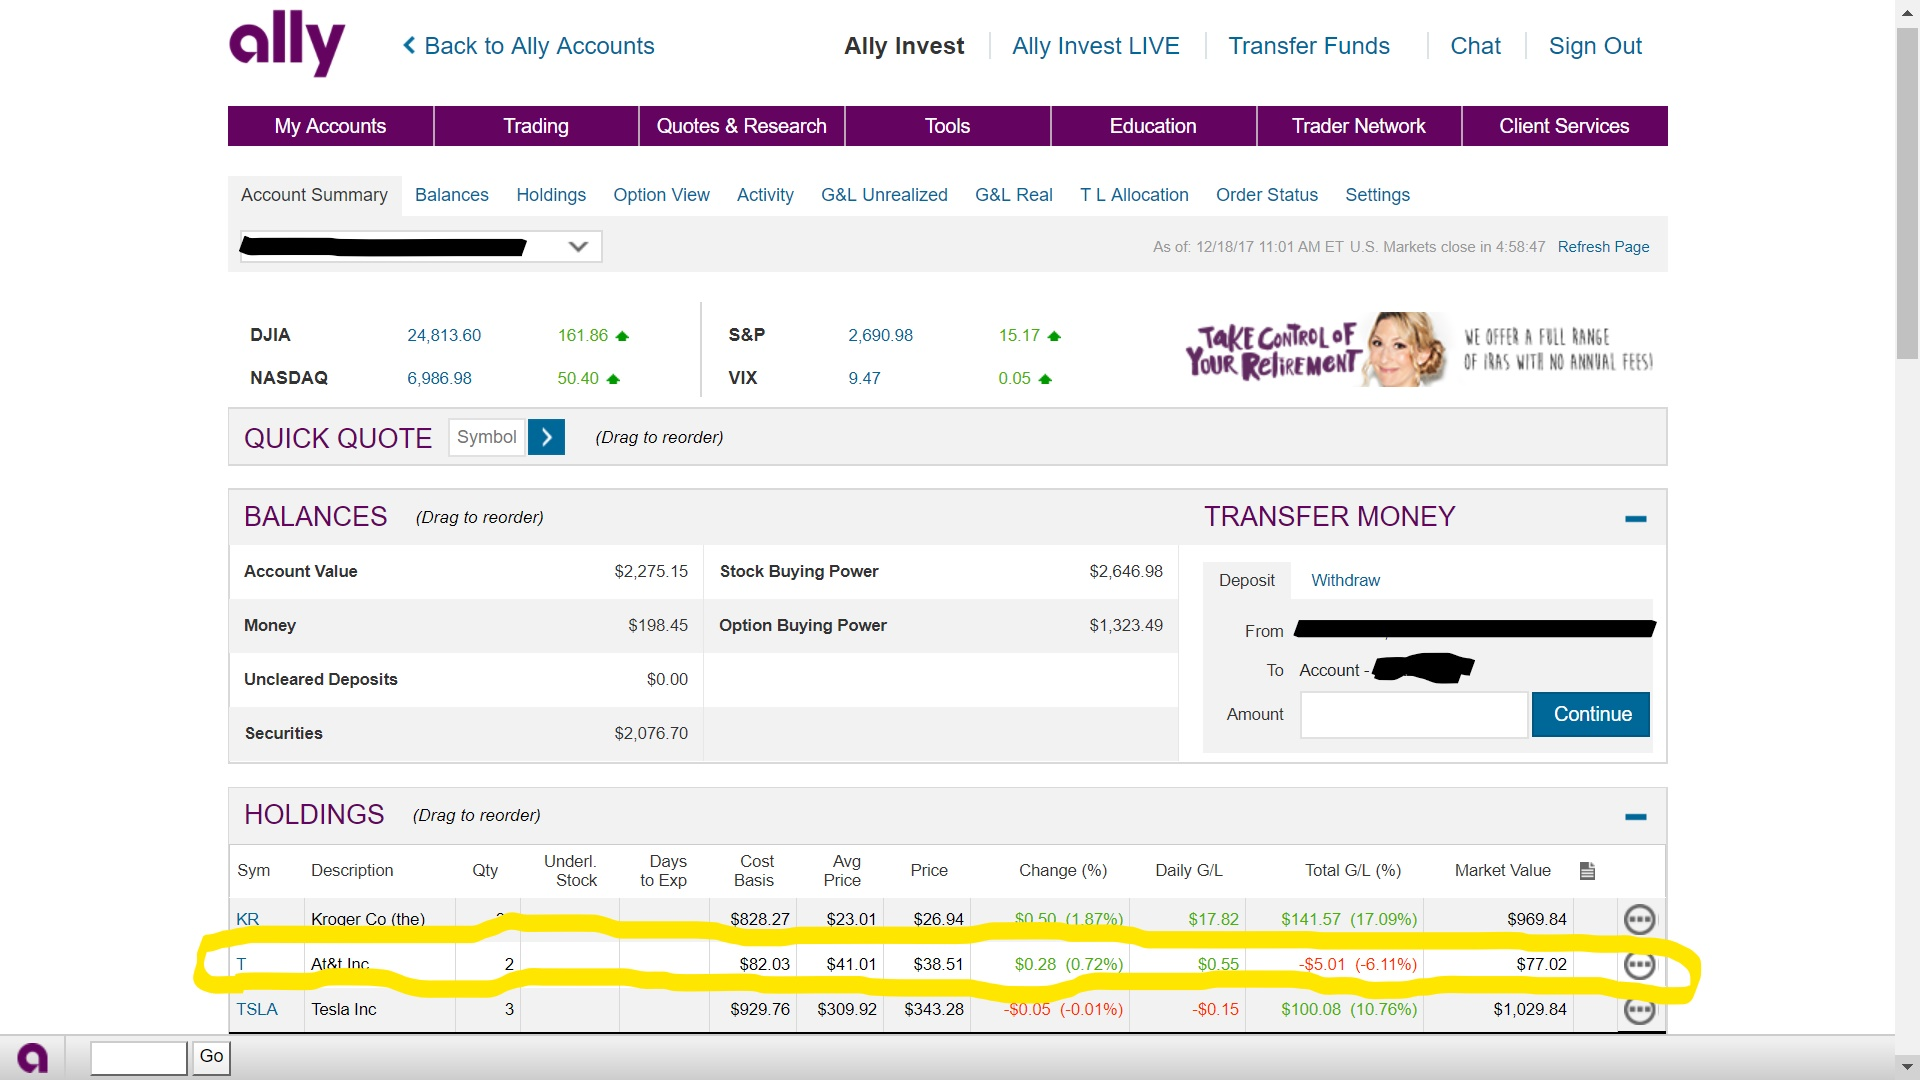

Hand in your two weeks' notice. We just traded two shares of AT&T stock using Python. Awe-some.

Make a call for the order history to see the trade executed.

In [6]:
from pprint import pprint
import requests
from requests_oauthlib import OAuth1

url = 'https://api.tradeking.com/v1/'
account = '[ENTER YOURS HERE]'
consumer_key = '[ENTER YOURS HERE]'
consumer_secret '[ENTER YOURS HERE]'
access_token = '[ENTER YOURS HERE]'
access_secret = '[ENTER YOURS HERE]'

oauth = OAuth1(consumer_key, consumer_secret, access_token, access_secret, signature_type='auth_header')

r = requests.get(url=url+'accounts/'+account+'/history.json', params={'range': 'today'}, auth=oauth)

# f = open(os.path.join(os.path.dirname((os.path.abspath(__file__))), "output_order_history.txt"), "w+")
# f.write(r)
# f.close()

pprint(r.json())

SyntaxError: invalid syntax (<ipython-input-6-ec07502c888b>, line 8)

Notice how we are adding parameters to the query by adding to the url. `Requests` lets us feed a dictionary of strings to the `params` keyword argument. This way we can filter our call by adding key/value pairs without appending them to the url by hand. Ally's API lets us filter the order history query down by date and type. See more [here](https://www.ally.com/api/invest/documentation/accounts-id-history-get/ "Transaction History").

In [13]:
import requests

url = 'https://api.tradeking.com/v1/'

params = {'range': 'today', 'transactions': 'trade'}
r = requests.get(url=url+'accounts/'+'12345678'+'/history.json', params=params)
print(r.url)
# Requests formats the query parameters and suffixes to the URL.

https://api.tradeking.com/v1/accounts/12345678/history.json?range=today&transactions=trade


This is the response. Ally says yes we did buy long two shares of AT&T. Hold off on that two weeks' notice though; all we've managed to do is become five dollars poorer from the transaction fee. So far, anyway.

Programming-wise, we've come a long ways. We will refactor the code later, put everything into nice functions and classes. For now, we are interested strictly in functional programming: make real things happen in the real world. And that is just what we are doing buying and selling stocks with an algorithm.

That's next.